# Sampling and calculating observables
## Generate new samples

Firstly, to generate meaningful data, an RBM needs to be trained. Please refer to the tutorials 1 and 2 on training an RBM if how to train an RBM using QuCumber is unclear. An RBM with a positive-real wavefunction describing a transverse-field Ising model (TFIM) with 10 sites has already been trained in the first tutorial, with the parameters of the machine saved here as `saved_params.pt`. The `autoload` function can be employed here to instantiate the corresponding `PositiveWaveFunction` object from the saved RBM parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qucumber
from qucumber.nn_states import PositiveWaveFunction
from qucumber.observables import ObservableBase

from quantum_ising_chain import TFIMChainEnergy, Convergence

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)
nn_state = PositiveWaveFunction.autoload("saved_params.pt", gpu=False)

A `PositiveWaveFunction` object has a property called `sample` that allows us to sample the learned distribution of TFIM chains. The it takes the following arguments (along with a few others which are not relevant for our purposes):

1. `k`: the number of Gibbs steps to perform to generate the new samples. Increasing this number will produce samples closer to the learned distribution, but will require more computation.
2. `num_samples`: the number of new data points to be generated

In [2]:
new_samples = nn_state.sample(k=100, num_samples=10000)
print(new_samples)

tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64)


### Magnetization

With the newly generated samples, the user can now easily calculate observables that do not require any information associated with the wavefunction and hence the RBM. These are observables which are diagonal in the computational (Pauli Z) basis. A great example of this is the magnetization (in the Z direction). To calculate the magnetization, the newly-generated samples must be converted to $\pm$ 1 from 1 and 0, respectively. The function below does the trick.

In [3]:
def to_pm1(samples):
    return samples.mul(2.0).sub(1.0)

Now, the (absolute) magnetization in the Z-direction is calculated as follows.

In [4]:
def Magnetization(samples):
    return to_pm1(samples).mean(1).abs().mean()


magnetization = Magnetization(new_samples).item()

print("Magnetization = %.5f" % magnetization)

Magnetization = 0.55752


The exact value for the magnetization is 0.5610. 

The magnetization and the newly-generated samples can also be saved to a pickle file along with the RBM parameters in the *PositiveWaveFunction* object.

In [5]:
nn_state.save(
    "saved_params_and_new_data.pt",
    metadata={"samples": new_samples, "magnetization": magnetization},
)

The `metadata` argument in the `save` function takes in a dictionary of data that you would like to save alongside the RBM parameters.

## Calculate an observable using the *Observable* module

### Magnetization (again)

QuCumber provides the `Observable` module to simplify estimation of expectations and variances of observables in memory efficient ways. To start off, we'll repeat the above example using the `SigmaZ` Observable module provided with QuCumber.

In [6]:
from qucumber.observables import SigmaZ

We'll compute the absolute magnetization again, for the sake of comparison with the previous example. We want to use the samples drawn earlier to perform this estimate, so we use the `statistics_from_samples` function:

In [7]:
sz = SigmaZ(absolute=True)
sz.statistics_from_samples(nn_state, new_samples)

{'mean': 0.5575200000000005,
 'variance': 0.09791724132414,
 'std_error': 0.0031291730748576373}

With this function we get the variance and standard error for free. Now you may be asking: "That's not too difficult, I could have computed those myself!". The power of the `Observable` module comes from the fact that it simplifies estimation of these values over a large number of samples. The `statistics` function computes these statistics by generating the samples internally. Let's see it in action:

In [8]:
%time sz.statistics(nn_state, num_samples=10000, burn_in=100)  
# just think of burn_in as being equivalent to k for now

CPU times: user 1.73 s, sys: 2.91 ms, total: 1.73 s
Wall time: 532 ms


{'mean': 0.5534800000000003,
 'variance': 0.09726161576157935,
 'std_error': 0.0031186794603097535}

Let's consider what is taking place under the hood at the moment. The `statistics` function is drawing 10000 samples from the given RBM state, and cycling it through the visible and hidden layers for 100 Block Gibbs steps before computing the statistics. This means that, at any given time it has to hold a matrix with 10000 rows and 10 (the number of lattice sites) columns in memory, which becomes infeasible for large lattices or if we want to use more samples to bring our standard error down. To bypass this issue, the `statistics` function allows us to specify the number of Markov Chains to evolve using the RBM, and will sample from these chains multiple times to produce enough samples. It takes the following arguments:

- `num_samples`: the number of samples to generate internally
- `num_chains`: the number of Markov chains to run in parallel (default = 0, meaning `num_chains` = `num_samples`)
- `burn_in`: the number of Gibbs steps to perform before recording any samples (default = 1000)
- `steps`: the number of Gibbs steps to perform between each sample; increase this to reduce the autocorrelation between samples (default = 1)

The `statistics` function will also return a dictionary containing the mean, standard error (of the mean) and the variance with the keys `mean`, `std_error` and `variance`, respectively.

In [9]:
%time sz.statistics(nn_state, num_samples=10000, num_chains=1000, burn_in=100, steps=2)

CPU times: user 320 ms, sys: 0 ns, total: 320 ms
Wall time: 82.4 ms


{'mean': 0.55116,
 'variance': 0.09716837123712346,
 'std_error': 0.003117184165831776}

In addition to using less memory (since the matrix held in memory is now of size `num_chains` x `num_sites` = 1000 x 10), using fewer chains also produced a decent speed boost! Next, we'll try increasing the total number of drawn samples:

In [10]:
sz.statistics(nn_state, num_samples=int(1e7), num_chains=1000, burn_in=100, steps=2)

{'mean': 0.5505669799999965,
 'variance': 0.09800984633466432,
 'std_error': 9.899992239121418e-05}

Note how much we reduced our standard error just by increasing the number of drawn samples. Finally, we can also draw samples of measurements **of the observable** using the `sample` function:

In [11]:
sz.sample(nn_state, k=100, num_samples=50)

tensor([0.6000, 0.2000, 0.0000, 0.4000, 0.6000, 0.8000, 0.6000, 0.2000, 0.2000,
        1.0000, 0.6000, 0.6000, 0.8000, 0.4000, 0.2000, 0.2000, 0.2000, 0.8000,
        0.6000, 0.2000, 0.2000, 0.8000, 0.6000, 0.6000, 0.8000, 1.0000, 0.4000,
        1.0000, 0.6000, 0.2000, 0.0000, 0.0000, 1.0000, 1.0000, 0.6000, 0.6000,
        0.2000, 1.0000, 0.2000, 1.0000, 0.8000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.2000, 0.4000, 0.6000], dtype=torch.float64)

Note that this function does not perform any fancy sampling tricks like `statistics` and is therefore susceptible to "Out of Memory" errors.

### TFIM Energy
Some observables cannot be computed directly from samples, but instead depend on the RBM as previously mentioned. For example, the magnetization of the TFIM simply depends on the samples the user gives as input. While we did provide the `nn_state` as an argument when calling `statistics_from_samples`, `SigmaZ` ignores it. The TFIM energy, on the other hand, is much more complicated. Consider the TFIM Hamiltonian:

$$H = -J\sum_i \sigma_i^z \sigma_{i+1}^z - h\sum_i \sigma_i^x$$

As our RBM was trained in the Z-basis, the off-diagonal transverse-field term is impossible to compute just from the samples; we need to know the value of the wavefunction for each sample as well. An example for the computation of the energy is provided in the python file `quantum_ising_chain.py`, which takes advantage of QuCumber's `Observable` module.

`quantum_ising_chain.py` comprises of a class that computes the energy of a TFIM (`TFIMChainEnergy`) that inherits properties from the `Observable` module. To instantiate a `TFIMChainEnergy` object, the $\frac{h}{J}$ value must be specified. The trained RBM parameters are from the first tutorial, where the example data was from the TFIM with 10 sites at its critical point ($\frac{h}{J}=1$). 

In [12]:
h = 1

tfim_energy = TFIMChainEnergy(h)

To go ahead and calculate the mean energy and its standard error from the previously generated samples from this tutorial (`new_samples`), the `statistics_from_samples` function in the `Observable` module is called upon.

In [13]:
energy_stats = tfim_energy.statistics_from_samples(nn_state, new_samples)
print("Mean: %.4f" % energy_stats["mean"], "+/- %.4f" % energy_stats["std_error"])
print("Variance: %.4f" % energy_stats["variance"])

Mean: -1.2353 +/- 0.0005
Variance: 0.0022


The exact value for the energy is -1.2381. 

To illustrate how quickly the energy converges as a function of the sampling step (i.e. the number of Gibbs steps to perform to generate a new batch of samples), `steps`, the `Convergence` function in `quantum_ising_chain.py` will do the trick. `Convergence` creates a batch of random samples initially, which is then used to generate a new batch of samples from the RBM. The TFIM energy will be calculated at every Gibbs step. Note that this function is not available in the QuCumber API; it is only used here as an illustrative example.

Text(0, 0.5, '% Error in Energy')

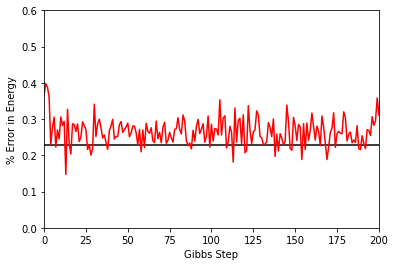

In [14]:
steps = 200
num_samples = 10000

dict_observables = Convergence(nn_state, tfim_energy, num_samples, steps)

energy = dict_observables["energies"]
err_energy = dict_observables["error"]

step = np.arange(steps + 1)

E0 = -1.2381

ax = plt.axes()
ax.plot(step, abs((E0 - energy) / E0) * 100, color="red")
ax.hlines(abs((E0 - energy_stats["mean"]) / E0) * 100, 0, 200, color="black")
ax.set_xlim(0, steps)
ax.set_ylim(0, 0.6)
ax.set_xlabel("Gibbs Step")
ax.set_ylabel("% Error in Energy")

One can see a brief transient period in the magnetization observable, before the state of the machine "warms up" to equilibrium (this explains the `burn_in` argument we saw earlier).  After that, the values fluctuate around the estimated mean (the horizontal black line).

### Adding observables

One may also add / subtract and multiply observables with each other or with real numbers. To illustrate this, we will build an alternative implementation of the TFIM energy observable. First, we will introduce the built-in `NeighbourInteraction` observable:

In [15]:
from qucumber.observables import NeighbourInteraction

The TFIM chain we trained the RBM on did not have periodic boundary conditions, so `periodic_bcs=False`.
Meanwhile, `c` specifies the between interacting spins, that is, a given site will only interact with a site `c` places away from itself; we set this to 1 as the TFIM chain has nearest-neighbour interactions.

In [16]:
nn_inter = NeighbourInteraction(periodic_bcs=False, c=1)

Next, we need the `SigmaX` observable, which computes the magnetization in the X-direction:

In [17]:
from qucumber.observables import SigmaX

Next, we build the Hamiltonian, setting $h = J = 1$:

In [18]:
h = J = 1
sx = SigmaX()
tfim = -J * nn_inter - h * sx

The same statistics of this new TFIM observable can also be calculated.

In [19]:
new_tfim_stats = tfim.statistics_from_samples(nn_state, new_samples)
print("Mean: %.4f" % new_tfim_stats["mean"], "+/- %.4f" % new_tfim_stats["std_error"])
print("Variance: %.4f" % new_tfim_stats["variance"])

Mean: -1.2353 +/- 0.0005
Variance: 0.0022


The statistics above match with those computed earlier.

### Rényi Entropy and the Swap operator

We can estimate the second Rényi Entropy using the Swap operator as shown by [Hastings et al. (2010)](https://link.aps.org/doi/10.1103/PhysRevLett.104.157201).
The second Rényi Entropy, in terms of the expectation of the Swap operator is given by:

$$S_2(A) = -\ln\langle \text{Swap}_A \rangle$$

where $A$ is the subset of the lattice for which we wish to compute the Rényi entropy.

In [20]:
from qucumber.observables import SWAP

As an example, we will take the region $A$ consist of sites $0$ through $4$ (inclusive).

In [21]:
A = [0, 1, 2, 3, 4]
swap = SWAP(A)

swap_stats = swap.statistics_from_samples(nn_state, new_samples)
print("Mean: %.4f" % swap_stats["mean"], "+/- %.4f" % swap_stats["std_error"])
print("Variance: %.4f" % swap_stats["variance"])

Mean: 0.7812 +/- 0.0085
Variance: 0.3610


The second Rényi Entropy can be computed directly from the sample mean. The standard error of the entropy, from first-order error analysis, is given by the standard error of the Swap operator divided by the mean of the Swap operator.

In [22]:
S_2 = -np.log(swap_stats["mean"])
S_2_error = abs(swap_stats["std_error"] / swap_stats["mean"])


print("S_2: %.4f" % S_2, "+/- %.4f" % S_2_error)

S_2: 0.2469 +/- 0.0109


### Custom observable
QuCumber has a built-in module called `Observable` which makes it easy for the user to compute any arbitrary observable from the RBM. To see the the `Observable` module in action, an example observable called `PIQuIL`, which inherits properties from the `Observable` module, is shown below. 

The `PIQuIL` observable takes a $\sigma^z$ measurement at a site and multiplies it by the measurement two sites away from it. There is also a parameter, $P$ , that determines the strength of each of these interactions. For example, for the dataset $(-1,1,1,-1), (1,1,1,1)$ and $(1,1,-1,1)$ with $P = 2$, the `PIQuIL` for each data point would be $\left( 2(-1\times1) + 2(1\times-1) = -4 \right), \left( 2(1\times1) + 2(1\times1) = 4 \right)$ and $\left( 2(1\times-1) + 2(1\times1) = 0 \right)$, respectively.

In [23]:
class PIQuIL(ObservableBase):
    def __init__(self, P):
        self.name = "PIQuIL"
        self.symbol = "Q"
        self.P = P

    # Required : function that calculates the PIQuIL. Must be named "apply"
    def apply(self, nn_state, samples):
        samples = to_pm1(samples)
        interaction_ = 0.0
        for i in range(samples.shape[-1]):
            if (i + 3) > samples.shape[-1]:
                continue
            else:
                interaction_ += self.P * samples[:, i] * samples[:, i + 2]

        return interaction_


P = 0.05
piquil = PIQuIL(P)

The `apply` function is contained in the `Observable` module, but is overwritten here. The `apply` function in `Observable` will compute the observable itself and must take in the RBM (`nn_state`) and a batch of samples as arguments. Thus, any new class inheriting from `Observable` that the user would like to define must contain a function called `apply` that calculates this new observable. For more details on `apply`, we refer to the documentation:

In [24]:
help(ObservableBase.apply)

Help on function apply in module qucumber.observables.observable:

apply(self, nn_state, samples)
    Computes the value of the observable, row-wise, on a batch of
    samples.
    
    If we think of the samples given as a set of projective measurements
    in a given computational basis, this method must return the expectation
    of the operator with respect to each basis state in `samples`.
    It must not perform any averaging for statistical purposes, as the
    proper analysis is delegated to the specialized
    `statistics` and `statistics_from_samples` methods.
    
    Must be implemented by any subclasses.
    
    :param nn_state: The WaveFunction that drew the samples.
    :type nn_state: qucumber.nn_states.WaveFunctionBase
    :param samples: A batch of sample states to calculate the observable on.
    :type samples: torch.Tensor
    :returns: The value of the observable of each given basis state.
    :rtype: torch.Tensor



Although the `PIQuIL` observable could technically be computed without the first argument of `apply` since it does not ever use the `nn_state`, we still include it in the list of arguments in order to conform to the interface provided in the `ObservableBase` class.

Since we have already generated new samples of data, the `PIQuIL` observable's mean, standard error and variance on the new data can be calculated with the `statistics_from_samples` function in the `Observable` module. The user must simply provide the RBM and the samples as arguments. 

In [25]:
piquil_stats1 = piquil.statistics_from_samples(nn_state, new_samples)

The `statistics_from_samples` function returns a dictionary containing the mean, standard error and the variance with the keys "mean", "std_error" and "variance", respectively.

In [26]:
print(
    "Mean PIQuIL: %.4f" % piquil_stats1["mean"], "+/- %.4f" % piquil_stats1["std_error"]
)
print("Variance: %.4f" % piquil_stats1["variance"])

Mean PIQuIL: 0.1762 +/- 0.0016
Variance: 0.0244


**Exercise**: We notice that the `PIQuIL` observable is essentially a scaled next-nearest-neighbours interaction. 
(a) Construct an equivalent `Observable` object algebraically in a similar manner to the TFIM observable constructed above.
(b) Compute the statistics of this observable on `new_samples`, and compare to those computed using the `PIQuIL` observable.

In [27]:
# solve the above exercise here

## Estimating Statistics of Many Observables Simultaneously

One may often be concerned with estimating the statistics of many observables simultaneously. In order to avoid excess memory usage, it makes sense to reuse the same set of samples to estimate each observable. When we need a large number of samples however, we run into the same issue mentioned earlier: we may run out of memory storing the samples. QuCumber provides a `System` object to keep track of multiple observables and estimate their statistics efficiently.

In [28]:
from qucumber.observables import System
from pprint import pprint

At this point we must make a quick aside: internally, `System` keeps track of multiple observables through their `name` field (which we saw in the definition of the `PIQuIL` observable). This name is returned by Python's built-in `repr` function, which is automatically called when we try to display an `Observable` object in Jupyter:

In [29]:
piquil

PIQuIL

In [30]:
tfim

((-1 * NeighbourInteraction(periodic_bcs=False, c=1)) + -(1 * SigmaX))

Note how the TFIM energy observable's name is quite complicated, due to the fact that we constructed it algebraically as opposed to the `PIQuIL` observable which was built from scratch and manually assigned a name.
In order to assign a name to `tfim`, we do the following:

In [31]:
tfim.name = "TFIM"
tfim

TFIM

Now, back to `System`. We'd like to create a `System` object which keeps track of the absolute magnetization, the energy of the chain, the Swap observable (of region $A$, as defined earlier), and finally, the `PIQuIL` observable. 

In [32]:
tfim_system = System(sz, tfim, swap, piquil)

In [33]:
pprint(tfim_system.statistics_from_samples(nn_state, new_samples))

{'PIQuIL': {'mean': 0.1762100000000003,
            'std_error': 0.001561328717706924,
            'variance': 0.024377473647363472},
 'SWAP': {'mean': 0.781224606354762,
          'std_error': 0.008496861564043185,
          'variance': 0.3609832821925721},
 'SigmaZ': {'mean': 0.5575200000000005,
            'std_error': 0.0031291730748576373,
            'variance': 0.09791724132414},
 'TFIM': {'mean': -1.2352610861294844,
          'std_error': 0.00046690278177402333,
          'variance': 0.0021799820762832124}}


These all match with the values computed earlier. Next, we will compute these statistics from fresh samples drawn from the RBM:

In [34]:
%%time
pprint(
    tfim_system.statistics(
        nn_state, num_samples=10000, num_chains=1000, burn_in=100, steps=2
    )
)

{'PIQuIL': {'mean': 0.17379,
            'std_error': 0.0015479157581468803,
            'variance': 0.02396043194319431},
 'SWAP': {'mean': 0.7830991583139741,
          'std_error': 0.005470949215870374,
          'variance': 0.29931285322632656},
 'SigmaZ': {'mean': 0.54964,
            'std_error': 0.003127325543736316,
            'variance': 0.09780165056505646},
 'TFIM': {'mean': -1.2349506598849702,
          'std_error': 0.0004650847078076302,
          'variance': 0.002163037854365088}}
CPU times: user 752 ms, sys: 0 ns, total: 752 ms
Wall time: 189 ms


Compare this to computing these statistics on each observable individually:

In [35]:
%%time
pprint(
    {
        obs.name: obs.statistics(
            nn_state, num_samples=10000, num_chains=1000, burn_in=100, steps=2
        )
        for obs in [piquil, swap, sz, tfim]
    }
)

{'PIQuIL': {'mean': 0.17802,
            'std_error': 0.0015489118350594624,
            'variance': 0.023991278727872708},
 'SWAP': {'mean': 0.7692432466953973,
          'std_error': 0.005650065301986227,
          'variance': 0.31923237916708713},
 'SigmaZ': {'mean': 0.55176,
            'std_error': 0.0031242705303213816,
            'variance': 0.09761066346634646},
 'TFIM': {'mean': -1.2349127938983788,
          'std_error': 0.0004690854163096549,
          'variance': 0.0022004112779440226}}
CPU times: user 1.69 s, sys: 8 ms, total: 1.7 s
Wall time: 427 ms


Note the slowdown. This is, as mentioned before, due to the fact that the `System` object uses *the same samples* to estimate statistics for *all* of the observables it is keeping track of.

---
### Template for your custom observable
Here is a generic template for you to try using the `Observable` module yourself.

In [36]:
import torch
from qucumber.observables import ObservableBase


class YourObservable(ObservableBase):
    def __init__(self, your_constants):
        self.your_constants = your_constants
        self.name = "Observable_Name"

        # The algebraic symbol representing this Observable.
        # Returned by Python's built-in str() function
        self.symbol = "O"

    def apply(self, nn_state, samples):
        # arguments of "apply" must be in this order

        # calculate your observable for each data point
        obs = torch.tensor([42] * len(samples))

        # make sure the observables are on the same device and have the
        # same dtype as the samples
        obs = obs.to(samples)

        # return a torch tensor containing the observable values
        return obs